In [6]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
from arch import arch_model
import plotly.express as px
from python_module.pricing_model import SABRModel, BlackScholesModel

In [7]:
# -------
# DEFINE GARCH FUNCTION
# -------
def heston_nandi_garch_variance(omega, alpha, beta, gamma, epsilon_squared):
    T = len(epsilon_squared)
    variance_est = np.zeros(T)
    for t in range(T):
        if t == 0:
            variance_est[t] = (omega + alpha) / (1 - beta - alpha*(gamma**2))
        else:
            variance_est[t] = omega + beta * variance_est[t-1] + alpha * (es)
    return variance_est


def compute_garch_log_likelihood(params, epsilon_squared):
    T = len(epsilon_squared)
    omega = params[0]
    alpha = params[1]
    beta = params[2]
    variance_est = compute_garch_variance_est(omega, alpha, beta, epsilon_squared)
    likelihood = 0.5 * np.sum(np.log(2*np.pi) + np.log(variance_est) + (epsilon_squared/variance_est))
    return likelihood

def compute_garch_vol_forecast(epsilon_squared, horizon):
    scaling = 10000
    daily_steps_per_year = 250 
    epsilon_squared_scaled = np.array(epsilon_squared*scaling)
    bounds = ((0.0001, None),)*3
    params_initial = (0.1, 0.05, 0.92)
    
    res = minimize(compute_garch_log_likelihood, params_initial, args=(epsilon_squared_scaled), bounds=bounds)
    omega, alpha, beta = res.x
    omega = omega*(1/scaling)
    
    variance_est = compute_garch_variance_est(omega, alpha, beta, np.array(epsilon_squared))
    var_tpn = variance_est[-1] 
    for i in range(1, horizon):
        var_tpn = omega + alpha*var_tpn + beta*var_tpn
    vol_tpn = np.sqrt(var_tpn * daily_steps_per_year)
    return vol_tpn


In [143]:
# -------
# PARAMETERS
# -------
F = 100
T = 500/250
alpha = 0.1
beta = 1
rho = 0.9
nu = 0.5
n_steps = 250
n_paths = 10
r = 0

In [144]:
SABRModel.compute_option(F=100, K=95, T=T, alpha=alpha, beta=beta, rho=rho, nu=nu, r=r, option_type='call')

{'IV': 0.08943774492868235,
 'price': 7.814744626195619,
 'delta': 0.6803842946872948,
 'gamma': 0.02825897392551021,
 'vega': 0.5054837803792135,
 'theta': -0.004520932941514219,
 'vanna': -1.3679338880370648,
 'volga': 90.68664424367431}

In [145]:
# -------
# SIMULATE MONTECARLO PATH USING SABR MODEL
# -------
spot, vol = SABRModel.compute_montecarlo(F=F, T=T, alpha=alpha, beta=beta, rho=rho, nu=nu, n_steps=n_steps, n_paths=n_paths, seed=True)
spot = spot[0]
vol = vol[0]

In [146]:
# -------
# FIT EGARCH MODEL
# -------
returns = 100 * spot.pct_change().dropna()
model = arch_model(returns, vol='EGARCH', p=1, q=1, o=1, dist='normal', mean='Zero')
res = model.fit(disp='off')


In [147]:
# Set simulation parameters
n_simulations = 10000  # number of simulation paths
horizon = 252         # simulation horizon (e.g., trading days)

# Container for simulated return paths
simulated_returns = np.empty((n_simulations, horizon))

# Run simulations using the model's simulate method
for i in range(n_simulations):
    sim = model.simulate(res.params, horizon)
    simulated_returns[i, :] = sim['data']

In [148]:
df = pd.DataFrame(simulated_returns).transpose()/100
new_row = pd.DataFrame(index=[0], columns=df.columns)
new_row.loc[0, :] = 0
df = pd.concat([new_row, df], ignore_index=True)

In [149]:
ST = (df.add(1).cumprod()*100).iloc[-1]

In [150]:
px.histogram(ST)

In [151]:
(ST-95).clip(0).mean()

5.924149086831996

In [314]:
# -------
# PLOT RESULTS
# -------
df = pd.DataFrame()
df['sabr'] = vol
df['garch'] = np.sqrt((res.conditional_volatility/100))
df = df.dropna()
px.line(df)

In [315]:
spot.pct_change().std() * np.sqrt(250)

0.10442371702071772

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.579e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                3208.53
Distribution:                  Normal   AIC:                          -6407.06
Method:            Maximum Likelihood   BIC:                          -6382.52
                                        No. Observations:                 1000
Date:                Sun, Feb 23 2025   Df Residuals:                      999
Time:                        22:52:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.8276e-04  3.106e-04      0.589      0.556 

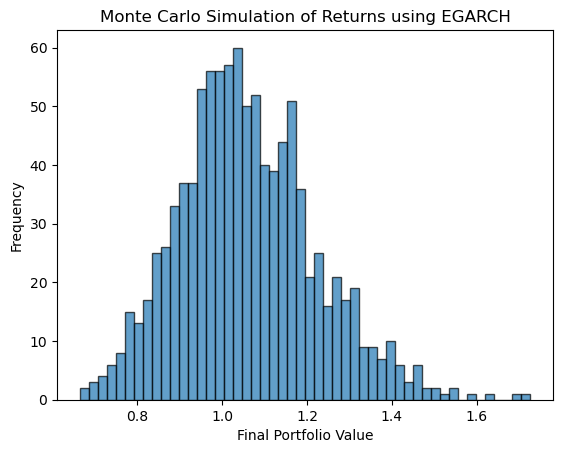

In [17]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Generate synthetic returns (replace with your data as needed)
np.random.seed(42)
n_obs = 1000
returns = np.random.randn(n_obs) / 100  # example daily returns

# Fit the EGARCH model
model = arch_model(returns, vol='EGARCH', p=1, o=1, q=1, dist='Normal')
res = model.fit(disp='off')
print(res.summary())

# Set simulation parameters
n_simulations = 1000  # number of simulation paths
horizon = 252         # simulation horizon (e.g., trading days)

# Container for simulated return paths
simulated_returns = np.empty((n_simulations, horizon))

# Run simulations using the model's simulate method
for i in range(n_simulations):
    sim = model.simulate(res.params, horizon)
    simulated_returns[i, :] = sim['data']

# Calculate final portfolio values (assuming log returns and an initial value of 1)
final_values = np.exp(np.sum(simulated_returns, axis=1))

# Plot the histogram of final portfolio values
plt.hist(final_values, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation of Returns using EGARCH')
plt.show()
